<a href="https://colab.research.google.com/github/GrigoVyd/map_cluster/blob/main/graph_clustering_qubo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Географическая кластеризация**

Задача: разбить почтовые индексы на сбалансированный набор кластеров.



> *Техническое задание:*


Набор кластеров называется сбалансированным, если:

1.   Никакой кластер не пересекается с другим(и) кластерами
2.   Не находится внутри другого кластера
3.   Граничит с другими кластерами
4.   Численность в каждом кластере отличается до 5%


[Общее задание, от которого отталкивались](https://docs.google.com/document/d/1se50OxFSV18lYcep0PLjNyc3lRuBGSiwXJF6wfZ8awc/edit?usp=sharing)


Участники:

*   Выдревич Григорий


# **Сложности и мотивация:**

Стандартные алгоритмы компонентной связности занимают очень много времени на большом объеме данных, а результаты полученной кластеризации не являются компактными. Соответственно, чтобы избавиться от последовательных циклов и перебора - мы решили применить алгоритмы машинного обучения. В данном случае можно приминить алгоритмы класстеризации основе заданных параметров.



Пояснение: компонентная связность - это алгоритм на графах, который позволяет рассмотреть множество таких вершин графа, что между любыми двумя вершинами существует маршрут. В данном случае мы пытаемся составить такой набор подграфов нашего датасета, что сумма значений вершин каждого была оптимальна. Из-за высокой связности датасета - такое решение невозможно реализовать за разумное время, хотя этот способ даст наиболее равные группы.

[Изначальный набор данных](https://docs.google.com/spreadsheets/d/1u7FWXcrPOyVl3awOMhglfqyYY0H32YjTkMlzKrN72ko/edit#gid=565044218)



[Расширенный набор данных](https://drive.google.com/drive/folders/1oB6Drl6SDJ31VHO53WrQ1jSw1dLfm34t?usp=sharing)

# **Часть 1: Подготовка данных и изучение датасета**

Данные найдены в американской базе переписи насения

In [1]:
pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 12.6 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import matplotlib.pyplot as plt

import json
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from shapely.geometry import Polygon, MultiPolygon

In [4]:
# Opening JSON file
f = open('/content/drive/MyDrive/County/CountyCodesShapes3.json')

# returns JSON object as a dictionary
data = json.load(f)
print(data)
# Iterating through the json ist

df = pd.DataFrame(data)

# Closing file
f.close()

[{'STATE': 'IA', 'County': '19077', 'Sum_POPESTIMATE2021': 10567}, {'STATE': 'GA', 'County': '13023', 'Sum_POPESTIMATE2021': 12607}, {'STATE': 'SC', 'County': '45089', 'Sum_POPESTIMATE2021': 30484}, {'STATE': 'OK', 'County': '40087', 'Sum_POPESTIMATE2021': 43516}, {'STATE': 'ND', 'County': '38009', 'Sum_POPESTIMATE2021': 6390}, {'STATE': 'SC', 'County': '45007', 'Sum_POPESTIMATE2021': 206908}, {'STATE': 'ID', 'County': '16059', 'Sum_POPESTIMATE2021': 8162}, {'STATE': 'SD', 'County': '46003', 'Sum_POPESTIMATE2021': 2748}, {'STATE': 'WV', 'County': '54069', 'Sum_POPESTIMATE2021': 41776}, {'STATE': 'KS', 'County': '20193', 'Sum_POPESTIMATE2021': 7877}, {'STATE': 'NV', 'County': '32001', 'Sum_POPESTIMATE2021': 25723}, {'STATE': 'ND', 'County': '38091', 'Sum_POPESTIMATE2021': 1810}, {'STATE': 'NC', 'County': '37117', 'Sum_POPESTIMATE2021': 21754}, {'STATE': 'KS', 'County': '20047', 'Sum_POPESTIMATE2021': 2832}, {'STATE': 'NC', 'County': '37181', 'Sum_POPESTIMATE2021': 42185}, {'STATE': 'CO'

Данные json файла содержат почтовые индексы и данные популяции

In [5]:
#install special library for geo data
!apt install gdal-bin python-gdal python3-gdal
!apt install python3-rtree
!pip install descartes
!pip install geopandas
import geopandas

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Package python-gdal is not available, but is referred to by another package.
This may mean that the package is missing, has been obsoleted, or
is only available from another source
However the following packages replace it:
  gdal-bin

E: Package 'python-gdal' has no installation candidate
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libspatialindex-c6 libspatialindex-dev libspatialindex6
The following NEW packages will be installed:
  libspatialindex-c6 libspatialindex-dev libspatialindex6 python3-rtree
0 upgraded, 4 newly installed, 0 to remove and 49 not upgraded.
Need to get 365 kB of archives.
After this operation, 1,799 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libspatialindex6 amd64 1.9.3-2 [247 kB]
Get:2 http://archive

<Axes: >

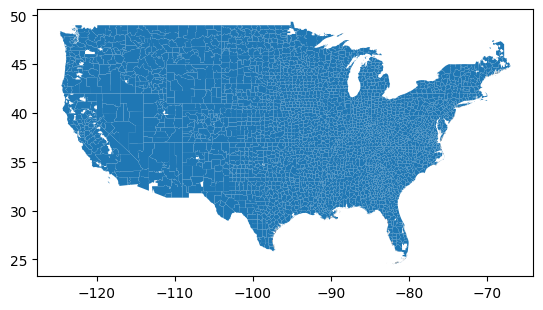

In [6]:
# Load the shapefile into a GeoDataFrame
gdf = geopandas.read_file("/content/drive/MyDrive/County/CountyCodesShapes1.SHX")

# Display the map
gdf.plot()

Данные формата geopandas содержит набор именнованных Полигонов (Polygon): элементарный геометрический объект географической базы данных ГИС, который определяет местоположение соответствующего площадного реального пространственного объекта

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


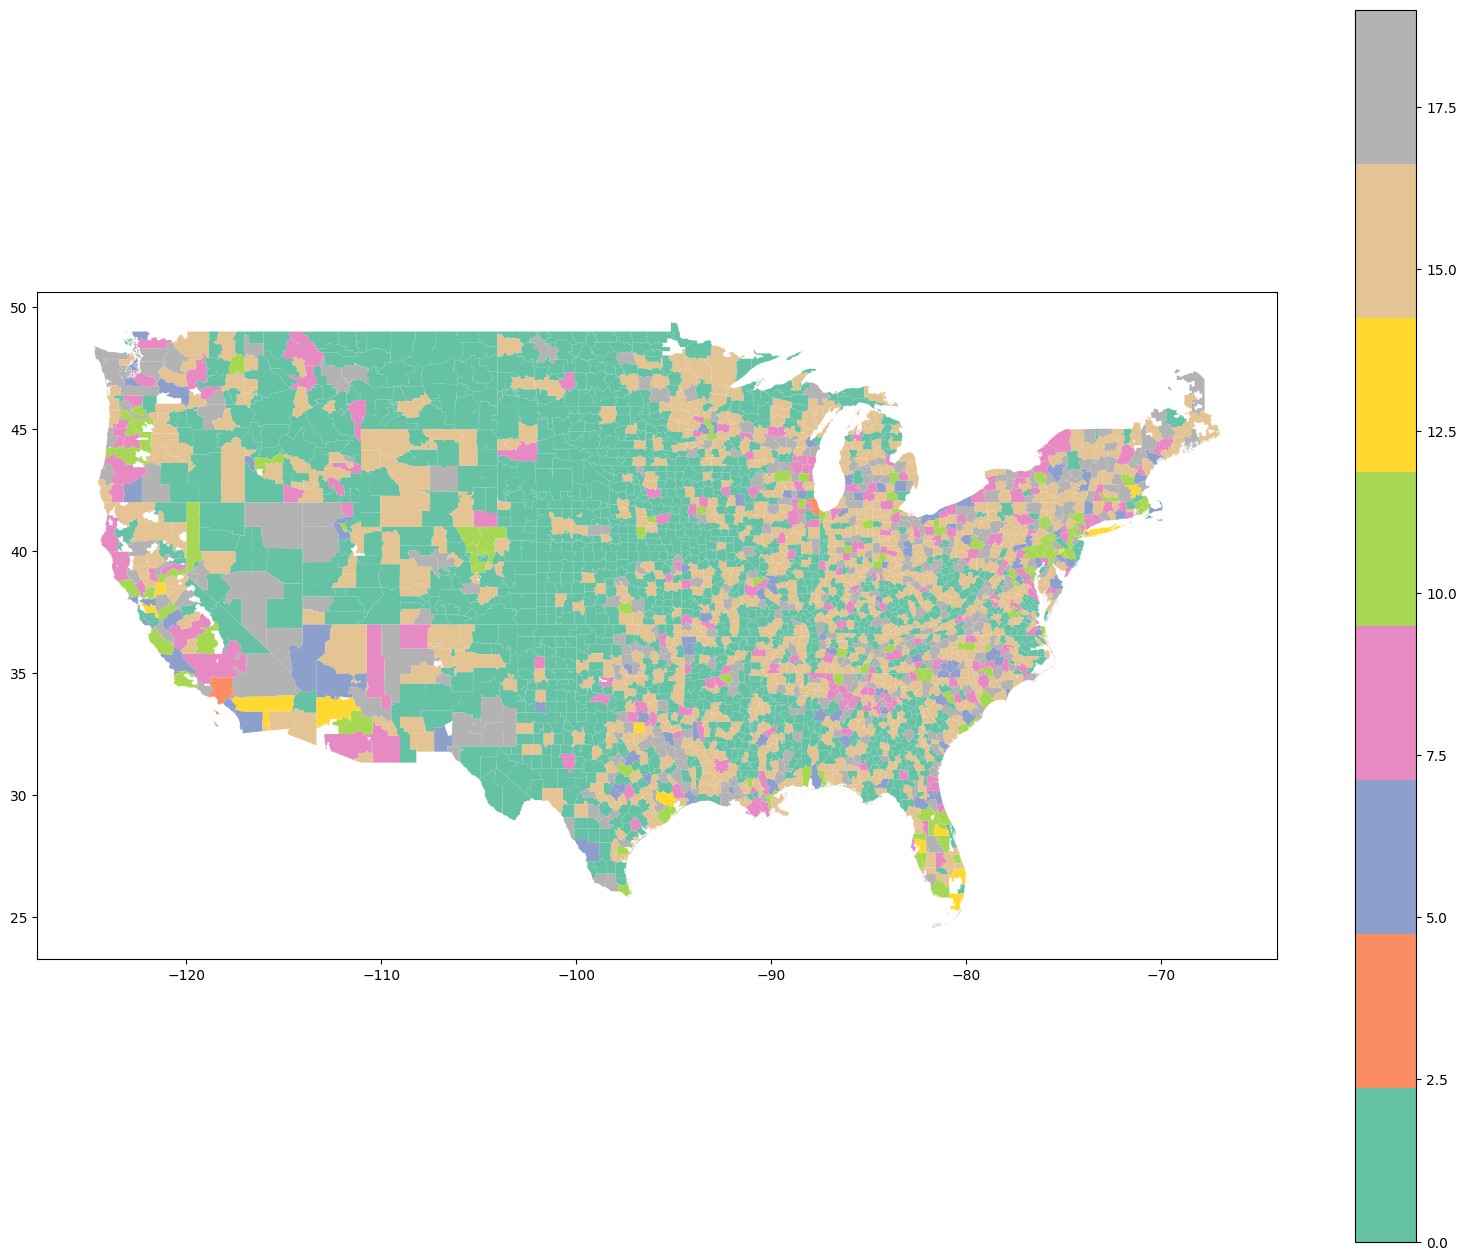

In [7]:
# creating more understandable names
regions = gdf
populations = df

# Merge population data with shapefile
regions = regions.merge(populations, on='County')
# Select population data as the feature for clustering
X = regions[['Sum_POPESTIMATE2021']]

# Define number of clusters
k = 20

# Cluster regions by population using K-means algorithm
kmeans = KMeans(n_clusters=k, random_state=0).fit(X)

# Add predicted cluster labels to regions dataframe
regions['cluster'] = kmeans.labels_

# Plot clustered regions on a map
fig, ax = plt.subplots(figsize=(20, 16))
regions.plot(ax=ax, column='cluster', cmap='Set2', legend=True)
plt.show()

После объединения этих данных в единый массив - мы провели оценку для далнейшей кластеризации, а именно как распределена популяции по данному массиву. Видно система индексов и штатов соотносится неравномерно - в некоторых регионах высокая плотность при малом размере, где-то наоборот. При этом на восточном побережье плотность отдельных регионов увеличена. Цвета показывают принадлежность к кластеру.

In [8]:
regions.keys()

Index(['STATE_x', 'County', 'Sum_POPEST', 'geometry', 'STATE_y',
       'Sum_POPESTIMATE2021', 'cluster'],
      dtype='object')

In [9]:
regions['geometry']

,geometry
0,"POLYGON ((-94.24966 41.71726, -94.26073 41.717..."
1,"POLYGON ((-83.19965 32.33503, -83.19966 32.334..."
2,"POLYGON ((-79.43327 33.62159, -79.43366 33.620..."
3,"POLYGON ((-96.88814 34.92717, -96.88874 34.927..."
4,"POLYGON ((-99.96638 48.53873, -99.96641 48.537..."
...,...
3114,"POLYGON ((-87.95295 40.47132, -87.96262 40.471..."
3115,"POLYGON ((-123.15750 42.39212, -123.15751 42.3..."
3116,"POLYGON ((-83.42326 37.94764, -83.42388 37.945..."
3117,"POLYGON ((-88.77306 36.90917, -88.77384 36.905..."


In [38]:
ngdf = gdf.copy()

In [39]:
ngdf

,STATE,County,Sum_POPEST,geometry
0,IA,19077,10567.0,"POLYGON ((-94.24966 41.71726, -94.26073 41.717..."
1,GA,13023,12607.0,"POLYGON ((-83.19965 32.33503, -83.19966 32.334..."
2,SC,45089,30484.0,"POLYGON ((-79.43327 33.62159, -79.43366 33.620..."
3,OK,40087,43516.0,"POLYGON ((-96.88814 34.92717, -96.88874 34.927..."
4,ND,38009,6390.0,"POLYGON ((-99.96638 48.53873, -99.96641 48.537..."
...,...,...,...,...
995,CO,08033,2397.0,"POLYGON ((-107.86085 37.77552, -107.86126 37.7..."
996,MS,28025,18535.0,"POLYGON ((-88.47189 33.52708, -88.47197 33.526..."
997,IN,18113,47227.0,"POLYGON ((-85.14594 41.26855, -85.14787 41.265..."
998,IL,17117,44406.0,"POLYGON ((-89.57115 39.50979, -89.58229 39.509..."


In [40]:
ngdf = ngdf.to_crs(epsg=4326)

<ipython-input-41-1df71c7c9ed4>:7: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = ngdf.geometry.centroid


<Figure size 2000x1600 with 0 Axes>

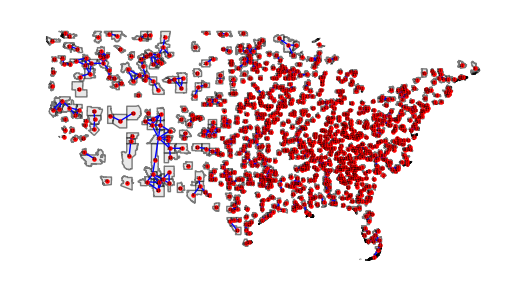

In [41]:
import networkx as nx

# Create an empty graph
G = nx.Graph()

# Calculate centroids and add them as nodes
centroids = ngdf.geometry.centroid
for idx, centroid in centroids.items():
    G.add_node(idx, pos=(centroid.x, centroid.y))

# Add edges between centroids of polygons that share a boundary
for i, poly1 in ngdf.iterrows():
    for j, poly2 in ngdf.iterrows():
        if i < j and poly1.geometry.touches(poly2.geometry):  # or poly1.geometry.intersects(poly2.geometry)
            G.add_edge(i, j)

# Get node positions from centroid coordinates
pos = {i: (centroid.x, centroid.y) for i, centroid in centroids.items()}

# Plot the centroids and connections
plt.figure(figsize=(20, 16))

# Plot centroids
ngdf.plot(color='lightgray', edgecolor='black', alpha=0.5)
nx.draw(G, pos, with_labels=True, node_size=5, node_color='red', edge_color='blue', font_size=2)

plt.show()

<ipython-input-42-8dfe4486e413>:11: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = ngdf.geometry.centroid


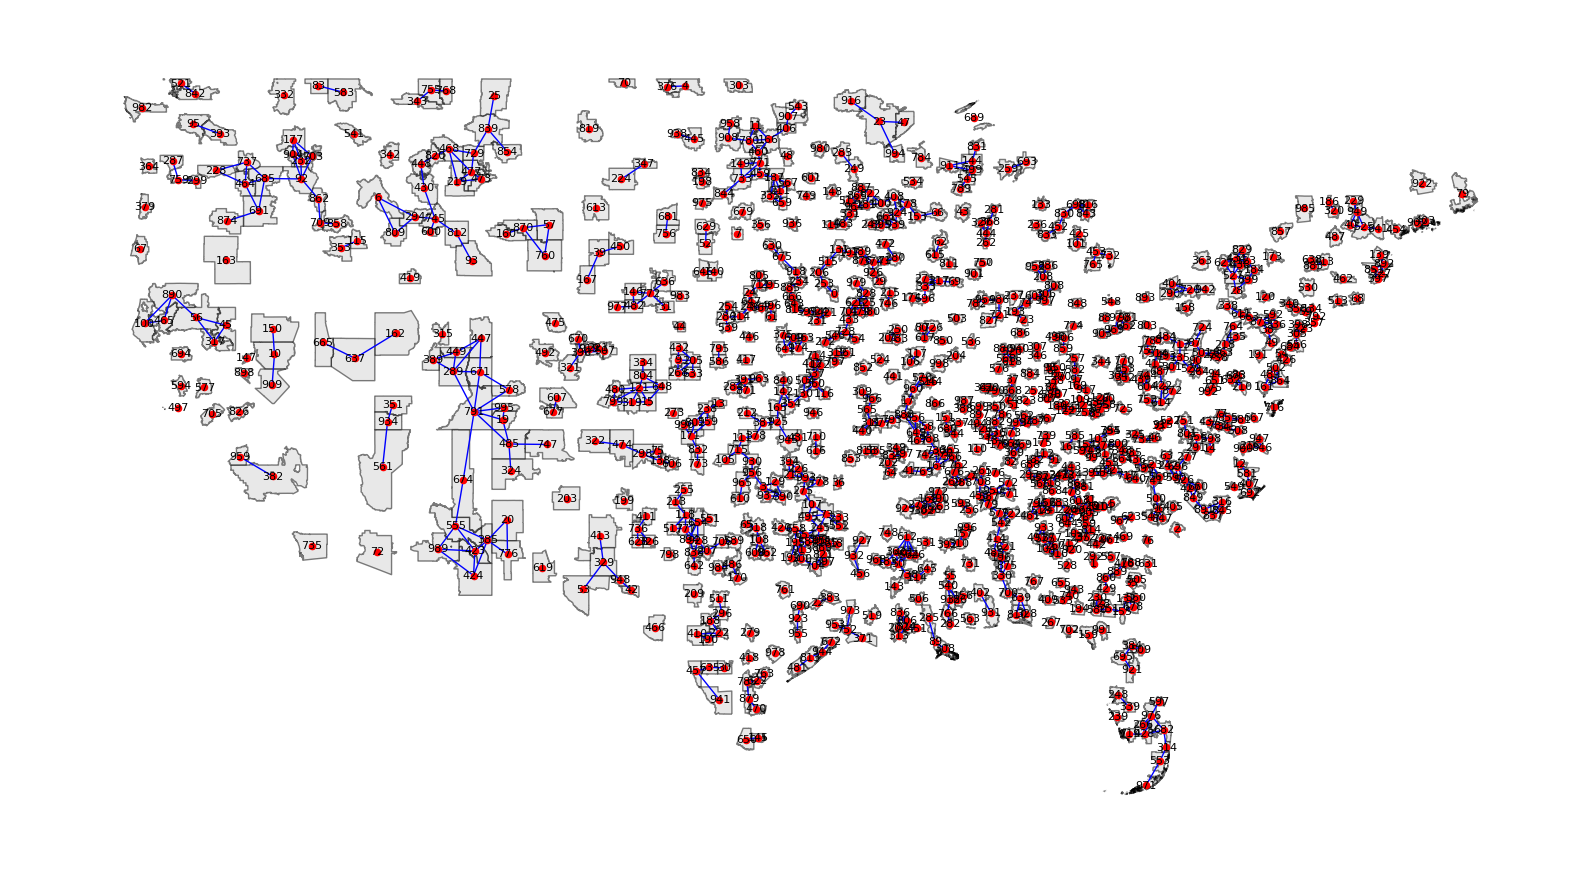

In [42]:
import networkx as nx
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have a GeoDataFrame ngdf with polygons
# Step 1: Create an empty graph
G = nx.Graph()

# Step 2: Calculate centroids and add them as nodes
centroids = ngdf.geometry.centroid
for idx, centroid in centroids.items():
    G.add_node(idx, pos=(centroid.x, centroid.y))

nodes = list(G.nodes())

# Initialize a distance matrix
distance_matrix = np.zeros((len(nodes), len(nodes)))

# Step 3: Add edges between polygons that share boundaries
for i, poly1 in ngdf.iterrows():
    for j, poly2 in ngdf.iloc[i+1:].iterrows():  # Avoid redundant checks
        if poly1.geometry.touches(poly2.geometry):
            # Calculate the Euclidean distance between centroids and add as edge weight
            distance = poly1.geometry.centroid.distance(poly2.geometry.centroid)
            G.add_edge(i, j, weight=distance)
            distance_matrix[i, j] = distance

# Step 4: Get node positions from centroid coordinates
pos = {i: (centroid.x, centroid.y) for i, centroid in centroids.items()}

# Step 5: Plot the graph (Optional)
plt.figure(figsize=(20, 16))
ngdf.plot(ax=plt.gca(), color='lightgray', edgecolor='black', alpha=0.5)
nx.draw(G, pos, with_labels=True, node_size=20, node_color='red', edge_color='blue', font_size=8)
plt.show()

In [15]:
# # Step 6: Compute the distance matrix using shortest paths

# # Populate the distance matrix with shortest path distances
# for i, node_i in enumerate(nodes):
#     for j, node_j in enumerate(nodes):
#         if i != j:
#             try:
#                 # Calculate shortest path using edge weights (distances)
#                 distance_matrix[i, j] = nx.shortest_path_length(G, source=node_i, target=node_j, weight='weight')
#             except nx.NetworkXNoPath:
#                 # If no path exists, set to infinity
#                 distance_matrix[i, j] = np.inf

# # Step 7: Output the distance matrix
# print("Distance Matrix:")
# print(distance_matrix)

In [43]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data

In [44]:
k = 4
max_distance = 15
ideal_population = np.sum(ngdf['Sum_POPEST']) / k
populations = ngdf['Sum_POPEST']
n = len(ngdf)
distances = distance_matrix

# # Assign a numerical index to each region for easier manipulation
region_index = {region: i for i, region in enumerate(ngdf.index.to_list())}

def qubo_objective(x, region_index, populations, ideal_population, G, distances, k, max_distance, lambda_1=1e6, lambda_2=1, lambda_3=1e6, lambda_4=1):
    # Reshape x into a k x n matrix (k colors, n regions)
    x = np.reshape(x, (k, -1))
    # Penalty for inter-cluster edges (regions connected by an edge but in different clusters)
    edge_penalty = 0
    for u, v in G.edges():
        i, j = region_index[u], region_index[v]
        edge_penalty += 1 - np.dot(x[:, i], x[:, j])  # Penalty if u and v are not in the same cluster

    # Penalty for deviation from the ideal cluster size
    cluster_sizes = np.dot(x, populations)

    size_penalty = np.sum((cluster_sizes - ideal_population) ** 2)

    # Penalty for intra-cluster distances (minimize distances within the same cluster)
    distance_penalty = 0
    for c in range(k):
        # for i in range(len(region_index)):
        #     for j in range(i + 1, len(region_index)):
        #         distance_penalty += distances[i, j] * x[c, i] * x[c, j]

        nodes_with_color = [n for n, attr in G.nodes(data=True) if x[c, n] == 1]

        # Build the subgraph
        subgraph = G.subgraph(nodes_with_color).copy()
        if nx.is_connected(subgraph):
          # If the graph is connected, we calculate the diameter
          diam = nx.diameter(subgraph)
          print(diam)
          distance_penalty += (diam - max_distance) ** 2 if diam > max_distance else 0
        else:
          distance_penalty += (max_distance * 1000) ** 2


    # # Penalty for exceeding maximum distance within clusters
    # compactness_penalty = 0
    # for c in range(k):
    #     for i in range(len(region_index)):
    #         for j in range(i + 1, len(region_index)):
    #             if distances[i, j] > max_distance:
    #                 compactness_penalty += x[c, i] * x[c, j]  # Penalty if both regions are in the same cluster

    print(edge_penalty, size_penalty, distance_penalty)
    # Total cost function
    return (lambda_1 * edge_penalty +
            lambda_2 * size_penalty +
            lambda_3 * distance_penalty)
            # lambda_4 * compactness_penalty)

initial_assignment = np.zeros((k, len(region_index)), dtype=int)

# Ensure each column sums to 1 (each region belongs to exactly one cluster)
for i in range(len(region_index)):
    # Randomly select a row (cluster) for this column (region) to assign a 1
    initial_assignment[np.random.randint(0, k), i] = 1

initial_assignment = initial_assignment.flatten()

# Optimize the QUBO
result = minimize(
    qubo_objective,
    initial_assignment,
    args=(region_index, populations, ideal_population, G, distances, k, max_distance),
    method='COBYLA',
    options={'maxiter': 20, 'disp': True}
)

# Extract the optimal cluster assignments
optimal_assignment = result.x.reshape((k, n)).round().astype(int)

# Map each region to a color
color_map = []
for i in range(n):
    color = np.argmax(optimal_assignment[:, i])
    color_map.append(color)

colors = ['red', 'green', 'blue', 'yellow']
node_colors = [colors[color] for color in color_map]

# Print population clusters
population_clusters = np.zeros(k)
for i, color in enumerate(color_map):
    population_clusters[color] += populations[i]
print("Population per cluster:", population_clusters)

719.0 48361375266540.75 900000000
719.0 48254250005718.25 900000000
719.0 48126735955813.75 900000000
719.0 47819717797803.75 900000000
717.0 47384668654813.75 900000000
717.0 47321103832678.75 900000000
717.0 45307009944040.75 900000000
716.0 45229314409123.75 900000000
716.0 45203185687285.75 900000000
716.0 44807828297053.75 900000000
716.0 44733673498308.25 900000000
716.0 44492379115453.75 900000000
716.0 44475450260568.75 900000000
716.0 44272498612615.75 900000000
716.0 44246147394943.75 900000000
716.0 43855523090516.25 900000000
716.0 43745092586958.25 900000000
715.0 43544076492850.75 900000000
714.0 43335917608236.25 900000000
713.0 43076718286596.25 900000000
Population per cluster: [20223326. 26379140. 28853773. 23669254.]


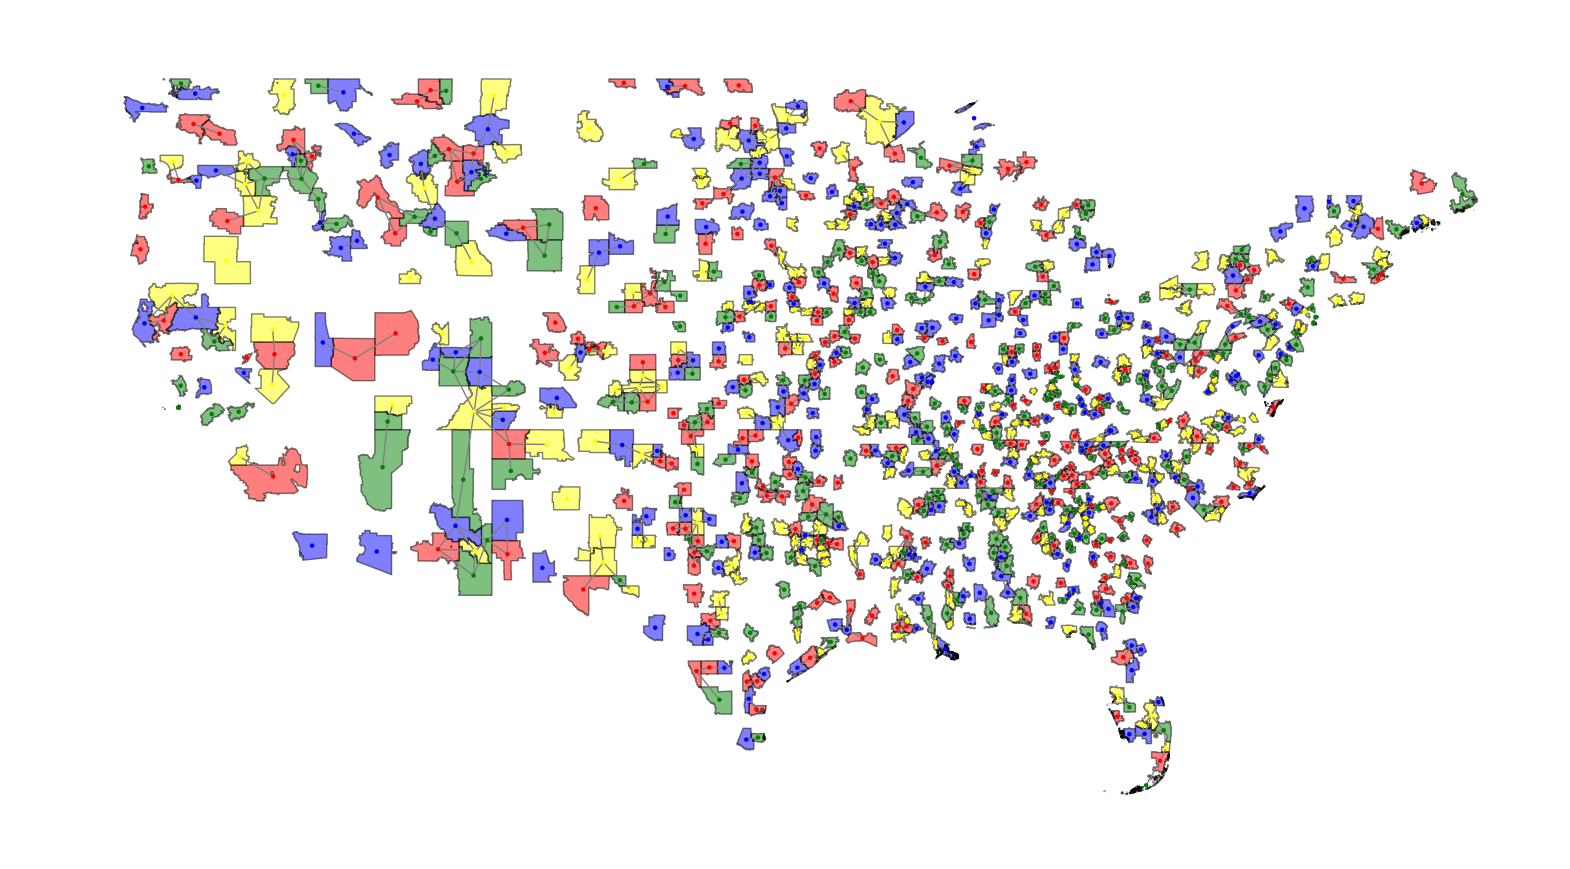

In [45]:
# Visualize the resulting clusters
plt.figure(figsize=(20, 16))
ngdf.plot(ax=plt.gca(), color=node_colors, edgecolor='black', alpha=0.5)
# nx.draw(G, pos, with_labels=True, node_size=5, node_color=node_colors, edge_color='gray')
nx.draw(G, pos, node_size=5, node_color=node_colors, edge_color='gray')
plt.show()

In [19]:
# # Convert the graph data for diffusion
# edge_index = torch.tensor([(region_index[u], region_index[v]) for u, v in G.edges()], dtype=torch.long).t().contiguous()
# edge_index = to_undirected(edge_index)  # Ensure undirected edges for diffusion

# data = Data(x=torch.tensor(populations, dtype=torch.float).unsqueeze(1), edge_index=edge_index)
# data.num_classes = k

# # Define Diffusion-Based Model
# class DiffusionModel(torch.nn.Module):
#     def __init__(self, input_dim, hidden_dim, output_dim):
#         super(DiffusionModel, self).__init__()
#         self.fc1 = torch.nn.Linear(input_dim, hidden_dim)
#         self.fc2 = torch.nn.Linear(hidden_dim, output_dim)

#     def forward(self, data):
#         x = F.relu(self.fc1(data.x))
#         x = self.fc2(x)
#         return F.log_softmax(x, dim=1)

# model = DiffusionModel(input_dim=1, hidden_dim=16, output_dim=data.num_classes)

# def compute_compactness_loss(output, edge_index, clusters, distances):
#     compactness_loss = 0
#     for edge in edge_index.t():
#         if clusters[edge[0]] == clusters[edge[1]]:
#             compactness_loss += (output[edge[0]] - output[edge[1]]).pow(2).sum()
#     return compactness_loss

# def compute_population_balance_loss(clusters, population, ideal_population, num_classes):
#     population_per_cluster = torch.zeros(num_classes)
#     for i in range(num_classes):
#         population_per_cluster[i] = population[clusters == i].sum()
#     balance_loss = torch.mean((population_per_cluster - ideal_population) ** 2)
#     return balance_loss

# def cluster_regularization(output, num_classes, min_nodes_per_cluster=2):
#     cluster_counts = torch.sum(output.exp(), dim=0)
#     too_few_nodes = torch.clamp(min_nodes_per_cluster - cluster_counts, min=0)
#     reg_loss = torch.sum(too_few_nodes)
#     return reg_loss

# def total_loss(output, data, clusters, distances, ideal_population, num_classes):
#     compactness_loss = compute_compactness_loss(output, data.edge_index, clusters, distances)
#     balance_loss = compute_population_balance_loss(clusters, data.x.squeeze(), ideal_population, num_classes)
#     smoothness_loss = F.nll_loss(output, clusters)
#     reg_loss = cluster_regularization(output, num_classes)
#     return compactness_loss + 10 * balance_loss + smoothness_loss + 2 * reg_loss

# def visualize_clusters(G, clusters, regions, colors, title):
#     node_colors = [colors[cluster] for cluster in clusters]
#     plt.figure(figsize=(8, 6))
#     nx.draw(G, with_labels=True, node_size=500, node_color=node_colors, edge_color='gray')
#     plt.title(title)
#     plt.show()

# optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
# model.train()

# for epoch in range(100):
#     optimizer.zero_grad()
#     output = model(data)
#     pred_clusters = output.argmax(dim=1)

#     loss = total_loss(output, data, pred_clusters, distances, ideal_population, data.num_classes)
#     loss.backward()
#     optimizer.step()

#     if epoch % 10 == 0:
#         print(f'Epoch {epoch}, Loss: {loss.item()}')
#         visualize_clusters(G, pred_clusters, regions, colors, f'Epoch {epoch}')

# model.eval()
# output = model(data)
# final_clusters = output.argmax(dim=1).detach().cpu().numpy()

# final_node_colors = [colors[cluster] for cluster in final_clusters]

# plt.figure(figsize=(8, 6))
# nx.draw(G, with_labels=True, node_size=500, node_color=final_node_colors, edge_color='gray')
# plt.title("Final Clusters After Diffusion Refinement")
# plt.show()